## <center> <font color='purple'> Dynamic Ensemble Machine Learning Models (Static Ensemble ML Pool)</font></center> 
#### <center>Firuz Juraev (Sungkyunkwan Unniversity)</center>

### <font color='green'> Libraries 

#### <font color='blue'> Basic Libraries 

In [26]:
import pandas as pd
import numpy as np 
import seaborn as sns 
from numpy import mean
from numpy import std
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#### <font color='blue'> Single ML Models Libraries 

In [2]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

#### <font color='blue'> Static ML Models Libraries 

In [3]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#### <font color='blue'> DES Libraries 

In [4]:
from deslib.des import DESP
from deslib.des import KNORAE
from deslib.des import KNORAU
from deslib.des import METADES
from deslib.des import DESKNN # new 
from deslib.des import KNOP # new 

#### <font color='blue'> DCS Libraries 

In [5]:
from deslib.dcs import MCB

#### <font color='blue'> Processing Libraries 

In [6]:
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score, 
                             f1_score,
                             roc_auc_score, 
                             auc)
from sklearn.metrics import roc_curve, roc_auc_score 
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#### <font color='blue'>Libraries for Critical Diagram 

In [32]:
from sklearn.model_selection import StratifiedKFold
from scipy.stats import wilcoxon, friedmanchisquare, rankdata
from Orange.evaluation import compute_CD, graph_ranks
from sklearn.metrics import mean_absolute_error

### <font color='green'> Load Dataset 

In [7]:
train_dataset_upsampled = pd.read_csv("Data/Resampled_neonates_train_data_4.csv")
test_dataset_upsampled = pd.read_csv("Data/Resampled_neonates_test_data_4.csv")

X_train = train_dataset_upsampled.drop(["DEAD"], axis=1) 
y_train = train_dataset_upsampled["DEAD"]

X_test = test_dataset_upsampled.drop(["DEAD"], axis=1) 
y_test = test_dataset_upsampled["DEAD"]

In [8]:
columns = X_train.columns.to_list()

### <font color='green'> Data Normalization

In [9]:
Min_max_scaler = MinMaxScaler().fit(X_train)

## Scaling 
X_train_mm_scaled = Min_max_scaler.transform(X_train)
X_test_mm_scaled = Min_max_scaler.transform(X_test)

## Numpy Array to DataFrame 
df_train_mm_scaled = pd.DataFrame(X_train_mm_scaled, columns = columns)
df_test_mm_scaled = pd.DataFrame(X_test_mm_scaled, columns = columns)

### <font color='green'> Feature Selection

In [10]:
tain_mm_scaled_df = df_train_mm_scaled[:]
tain_mm_scaled_df["DEAD"] = y_train 

test_mm_scaled_df = df_test_mm_scaled[:] 
test_mm_scaled_df["DEAD"] = y_test


importances = mutual_info_classif(df_train_mm_scaled, y_train)
feat_importance = pd.Series(importances, tain_mm_scaled_df.columns[0:len(tain_mm_scaled_df.columns)-1])
    
feat_importance = feat_importance.sort_values(ascending=False)
    
selected_features = feat_importance[:30]
selected_features_list_mm_scaled = selected_features.index.to_list()


tain_mm_scaled_df[selected_features_list_mm_scaled].head(2)

,temperature_mean,respRate_std,respRate_var,skinTemperature_std,skinTemperature_var,heartRate_std,heartRate_var,sao2_std,bpCuffMean_var,bpCuffMean_std,...,BIRTH_WEIGHT,bpCuffSystolic_mean,bpCuffDiastolic_mean,glucometer_mean,sao2_mean,temperature_std,temperature_var,bpCuffMean_mean,PLATELET,D10W_MEAN
0,0.775318,0.422245,0.178291,0.134078,0.017977,0.22911,0.057937,0.097817,0.053294,0.230854,...,0.264267,0.602649,0.457143,0.312593,0.881455,0.125281,0.015695,0.310696,0.281330,0.151138
1,0.709668,0.583964,0.341014,0.086672,0.007512,0.28258,0.086102,0.080938,0.020317,0.142539,...,0.437819,0.644907,0.479330,0.272551,0.926056,0.061399,0.003770,0.351928,0.392157,0.196784


In [11]:
X_train_mm = df_train_mm_scaled[selected_features_list_mm_scaled][:]
X_test_mm = df_test_mm_scaled[selected_features_list_mm_scaled][:]

### <font color='purple'> Hold-out Test (With Single ML) - (+FS, +HO)

In [12]:
def hold_out_single_ML(): 
    rng = np.random.RandomState(42) 
    X_train, X_dsel, y_train_en, y_dsel = train_test_split(X_train_mm, y_train, test_size=0.40, random_state=rng)
    
    model_ada = AdaBoostClassifier(n_estimators=250, learning_rate=0.01)
    model_xgb = XGBClassifier(learning_rate = 0.002, n_estimators=200, max_depth=3)
    model_rf  = RandomForestClassifier(criterion='gini', n_estimators=100, max_depth=2)
    model_cat = MLPClassifier(solver='adam', max_iter=11, verbose=10,learning_rate_init=.003)
    model_lgb = LGBMClassifier(max_depth=1, n_estimators=150, objective="binary")
    
    model_ada.fit(X_train, y_train_en)
    model_xgb.fit(X_train, y_train_en)
    model_rf.fit(X_train, y_train_en)
    model_cat.fit(X_train, y_train_en)
    model_lgb.fit(X_train, y_train_en) 
    
    classifiers_names = ["AdaBoost", "RandomForest", "CatBoost", "LGBM"]
    
    pool_classifiers = [model_ada, 
#                         model_xgb,
                        model_rf, 
                        model_cat, 
                        model_lgb] 
    
    c_acc_list = [] 
    
    for cls in pool_classifiers:
        y_preds_c = cls.predict(X_test_mm) 
        c_acc_list.append(accuracy_score(y_test, y_preds_c))           
        
        
    classifiers_results =  {'name': classifiers_names, 
                            'accuracy': c_acc_list}
    
    clsDF = pd.DataFrame.from_dict(classifiers_results)
        
    # DES STARTS
    
    knorau = KNORAU(pool_classifiers)
    kne = KNORAE(pool_classifiers)  
    metades = METADES(pool_classifiers)
    desknn = DESKNN(pool_classifiers)
    mcb = MCB(pool_classifiers)
    desp = DESP(pool_classifiers)
    knop = KNOP(pool_classifiers)

    fire_knorau = KNORAU(pool_classifiers, DFP=True, k=5) # 5 was 0.971
    fire_kne = KNORAE(pool_classifiers, DFP=True, k=9) # 9 was 0.974
    fire_metades = METADES(pool_classifiers, DFP=True, k=15) # 7 was 0.939
    fire_desknn = DESKNN(pool_classifiers, DFP=True, k=3) # 5 was 0.931 
    fire_mcb = MCB(pool_classifiers, DFP=True, k=9)
    fire_desp = DESP(pool_classifiers, DFP=True, k=5)
    fire_knop = KNOP(pool_classifiers, DFP=True, k=9)
    
    ensemble_classifiers = [fire_knorau, knorau, fire_kne, kne, fire_metades, metades, fire_desknn, desknn, 
                            fire_mcb, mcb, fire_desp, desp, fire_knop, knop]
    
    ensemble_names = ["FIRE-KNORA-U", "KNORA-U", "FIRE-KNORA-E", "KNORA-E", "FIRE-METADES", "METADES",
                      "FIRE-DESKNN", "DESKNN", "FIRE-MCB", "MCB", "FIRE-DESP", "DESP", "FIRE-KNOP", "KNOP"]
    
    acc_list = [] 
    precision_list = [] 
    recall_list = []
    f1_lists = [] 
    auc_list = [] 
    fpr_list = [] 
    tpr_list = []
    
    for e_cls in ensemble_classifiers:
        e_cls.fit(X_dsel, y_dsel)
        y_preds = e_cls.predict(X_test_mm) 
        yproba = e_cls.predict_proba(X_test_mm)[::,1] 

        acc_list.append(accuracy_score(y_test, y_preds))
        precision_list.append(precision_score(y_test, y_preds))
        recall_list.append(recall_score(y_test, y_preds))
        fone = f1_score(y_test, y_preds)
        f1_lists.append(fone) 
        
        fpr, tpr, _ = roc_curve(y_test,  yproba)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        auc = roc_auc_score(y_test, yproba)
        auc_list.append(auc) 
    
    results =  {'name': ensemble_names, 
                'accuracy': acc_list, 
                'precision': precision_list, 
                'recall': recall_list, 'f1': f1_lists, 
                'auc': auc_list, 
                'tpr': tpr_list, 'fpr': fpr_list}
    
    df = pd.DataFrame.from_dict(results)
    
    return df, clsDF

In [13]:
results_data = []
classifier_results_data = []
for i in range(0, 10):
    result, cls_results = hold_out_single_ML()
    results_data.append(result)
    classifier_results_data.append(cls_results)
    

fireResultsDF = pd.concat(results_data)
classifiersResultsDF = pd.concat(classifier_results_data)

[11:01:48] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Iteration 1, loss = 0.64701859
Iteration 2, loss = 0.52264718
Iteration 3, loss = 0.43800901
Iteration 4, loss = 0.38514804
Iteration 5, loss = 0.35462551
Iteration 6, loss = 0.33276253
Iteration 7, loss = 0.31600894
Iteration 8, loss = 0.30436737
Iteration 9, loss = 0.29356048
Iteration 10, loss = 0.28544545
Iteration 11, loss = 0.27906388
[11:01:57] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Iteration 1, loss = 0.63383219
Iteration 2, loss = 0.52207024
Iteration 3, loss = 0.43265380
Iteration 4, loss = 0.38171961
Iteration 5, loss = 0.3518628

In [14]:
ensemble_names = ["FIRE-KNORA-U", "KNORA-U", "FIRE-KNORA-E", "KNORA-E", "FIRE-METADES", "METADES",
                  "FIRE-DESKNN", "DESKNN", "FIRE-MCB", "MCB", "FIRE-DESP", "DESP", "FIRE-KNOP", "KNOP"]

accuracy = [] 
accuracy_std =  [] 
precision = [] 
precision_std = [] 
recall = [] 
recall_std = [] 
f1_score = [] 
f1_std = []
auc_score = []
auc_std = []


for n in ensemble_names:
    accuracy.append(round(fireResultsDF[fireResultsDF.name == n].accuracy.mean(), 3))
    accuracy_std.append(round(fireResultsDF[fireResultsDF.name == n].accuracy.std(), 3))
    precision.append(round(fireResultsDF[fireResultsDF.name == n].precision.mean(), 3))
    precision_std.append(round(fireResultsDF[fireResultsDF.name == n].precision.std(), 3))
    recall.append(round(fireResultsDF[fireResultsDF.name == n].recall.mean(), 3))
    recall_std.append(round(fireResultsDF[fireResultsDF.name == n].recall.std(), 3))
    f1_score.append(round(fireResultsDF[fireResultsDF.name == n].f1.mean(), 3))
    f1_std.append(round(fireResultsDF[fireResultsDF.name == n].f1.std(), 3))
    auc_score.append(round(fireResultsDF[fireResultsDF.name == n].auc.mean(), 3))
    auc_std.append(round(fireResultsDF[fireResultsDF.name == n].auc.std(), 3))
    
final_results = {"method": ensemble_names, 
                     "accuracy": accuracy, 
                     "accuracy_std": accuracy_std,
                     "precision": precision, 
                     "precision_std": precision_std,
                     "recall": recall, 
                     "recall_std": recall_std,
                     "f1_score": f1_score, 
                     "f1_std": f1_std, 
                     "auc": auc_score, 
                     "auc_std": auc_std}

finalResultsDF = pd.DataFrame.from_dict(final_results)

In [15]:
finalResultsDF

,method,accuracy,accuracy_std,precision,precision_std,recall,recall_std,f1_score,f1_std,auc,auc_std
0,FIRE-KNORA-U,0.969,0.002,0.942,0.004,1.000,0.000,0.970,0.002,0.987,0.000
1,KNORA-U,0.967,0.003,0.938,0.005,1.000,0.000,0.968,0.003,0.986,0.000
2,FIRE-KNORA-E,0.974,0.001,0.950,0.002,1.000,0.000,0.974,0.001,0.988,0.000
3,KNORA-E,0.975,0.001,0.952,0.002,1.000,0.000,0.975,0.001,0.988,0.000
4,FIRE-METADES,0.948,0.020,0.954,0.002,0.942,0.041,0.947,0.021,0.978,0.016
5,METADES,0.940,0.014,0.954,0.003,0.924,0.027,0.939,0.015,0.974,0.017
6,FIRE-DESKNN,0.934,0.010,0.959,0.001,0.907,0.020,0.932,0.011,0.985,0.001
7,DESKNN,0.935,0.010,0.961,0.002,0.907,0.020,0.933,0.012,0.985,0.001
8,FIRE-MCB,0.962,0.004,0.950,0.003,0.976,0.009,0.963,0.004,0.979,0.003
9,MCB,0.961,0.005,0.949,0.004,0.976,0.009,0.962,0.005,0.980,0.003


In [19]:
# finalResultsDF.to_csv("Results/static_pool_results/des_static_pool_results_4_models.csv", index=False)

In [16]:
classifiers_names = ["AdaBoost", "RandomForest", "CatBoost", "LGBM"]

accuracy_list = []
accuracy_std_list = []
for n in classifiers_names:
    accuracy_list.append(classifiersResultsDF[classifiersResultsDF.name == n].accuracy.mean())
    accuracy_std_list.append(classifiersResultsDF[classifiersResultsDF.name == n].accuracy.std())

final_cls_results = {"classifier": classifiers_names, 
                     "accuracy": accuracy_list, 
                     "accuracy_std": accuracy_std_list}

finalClassifierResultsDF = pd.DataFrame.from_dict(final_cls_results)

In [17]:
finalClassifierResultsDF

,classifier,accuracy,accuracy_std
0,AdaBoost,0.950378,0.000000e+00
1,RandomForest,0.958900,1.120722e-02
2,CatBoost,0.944930,1.074681e-02
3,LGBM,0.932039,2.340556e-16


In [18]:
finalResultsDF.describe().T

,count,mean,std,min,25%,50%,75%,max
accuracy,14.0,0.955786,0.016858,0.932,0.93925,0.9615,0.97050,0.975
accuracy_std,14.0,0.006929,0.006082,0.001,0.00200,0.0045,0.01000,0.020
precision,14.0,0.951000,0.006202,0.938,0.94925,0.9515,0.95400,0.961
precision_std,14.0,0.002643,0.001082,0.001,0.00200,0.0020,0.00300,0.005
recall,14.0,0.961500,0.040735,0.907,0.92250,0.9760,1.00000,1.000
recall_std,14.0,0.012357,0.013483,0.000,0.00000,0.0090,0.02000,0.041
f1_score,14.0,0.955571,0.017973,0.930,0.93825,0.9625,0.97150,0.975
f1_std,14.0,0.007357,0.006512,0.001,0.00200,0.0045,0.01175,0.021
auc,14.0,0.981643,0.007186,0.964,0.97825,0.9850,0.98700,0.988
auc_std,14.0,0.003500,0.005735,0.000,0.00000,0.0010,0.00300,0.017


### <font color='purple'> ROC Curve 

In [20]:
names = ["FIRE-KNORA-U", "KNORA-U", "FIRE-KNORA-E", "KNORA-E", "FIRE-METADES", "METADES",
         "FIRE-DESKNN", "DESKNN", "FIRE-MCB", "MCB", "FIRE-DESP", "DESP", "FIRE-KNOP", "KNOP"]

fpr_lists = []
tpr_lists = []

for n in names: 
    fpr_lists.append(fireResultsDF[fireResultsDF.name==n].fpr.to_list())
    tpr_lists.append(fireResultsDF[fireResultsDF.name==n].tpr.to_list())

In [21]:
def Extract(lst):
    return [item[7] for item in lst]

In [22]:
fpr_results = Extract(fpr_lists)
tpr_results = Extract(tpr_lists)

In [23]:
names = ["FIRE-KNORA-U", "KNORA-U", "FIRE-KNORA-E", "KNORA-E", "FIRE-METADES", "METADES",
         "FIRE-DESKNN", "DESKNN", "FIRE-MCB", "MCB", "FIRE-DESP", "DESP", "FIRE-KNOP", "KNOP"]


roc_results = {"models": names, 
              "auc": finalResultsDF.auc.to_list(), 
              "fpr": fpr_results, 
              "tpr": tpr_results}

res = pd.DataFrame.from_dict(roc_results)

res.set_index('models', inplace=True)

In [28]:
# res.to_csv("Results/static_pool_results/des_static_pool_results_4_table_for_ROC.csv", index=False)

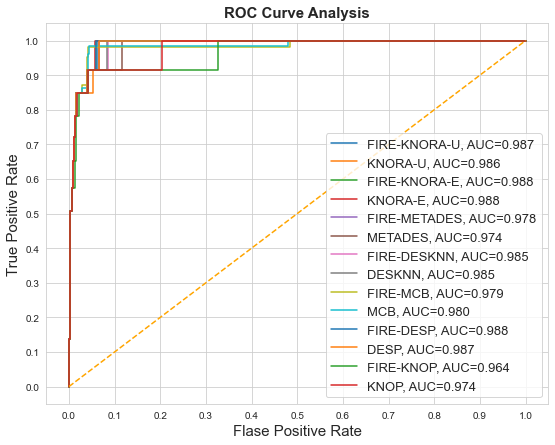

In [27]:
fig = plt.figure(figsize=(9,7))
sns.set_style("whitegrid")
for i in res.index:
    plt.plot(res.loc[i]['fpr'], 
             res.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, res.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

### <font color='purple'> Critical Diagram 

In [29]:
def compare_results(results, lst_models):      
        fried_result = friedmanchisquare(*results)
        
        ranks = np.array([rankdata(-p) for p in results])
        
        # Calculating the average ranks.
        average_ranks = np.mean(ranks, axis=0)

        names = [lst_models[i] + ' - ' + str(round(average_ranks[i], 3)) for i in range(len(average_ranks))]
        
        # This method computes the critical difference for Nemenyi test with alpha=0.1.
        # For some reason, this method only accepts alpha='0.05' or alpha='0.1'.
        cd = compute_CD(average_ranks, n=len(results),alpha='0.05', test='nemenyi')
        
        return fried_result, ranks, names, cd, average_ranks

In [30]:
def plot_comparisons(fried_result, names, cd, average_ranks):    
    # This method generates the plot.
    graph_ranks(average_ranks, names=names,
                        cd=cd, width=10, textspace=1.5)
        
    plt.title(f'Friedman-Nemenyi={round(fried_result.pvalue, 4)}\nCD={round(cd, 3)}')
    plt.show()
    
    return

In [33]:
names = ["FIRE-KNORA-U", "KNORA-U", "FIRE-KNORA-E", "KNORA-E", "FIRE-METADES", "METADES",
         "FIRE-DESKNN", "DESKNN", "FIRE-MCB", "MCB", "FIRE-DESP", "DESP", "FIRE-KNOP", "KNOP"]

dct_results = {}

for n in names:
    res = fireResultsDF[fireResultsDF.name == n].accuracy.to_list()
    dct_results[n] = res

results = np.c_[dct_results['FIRE-KNORA-U'], dct_results['KNORA-U'], dct_results['FIRE-KNORA-E'], 
                dct_results['KNORA-E'], dct_results['FIRE-METADES'], dct_results['METADES'], 
                dct_results['FIRE-DESKNN'], dct_results['DESKNN'], dct_results['FIRE-MCB'], 
                dct_results['MCB'], dct_results['FIRE-DESP'], dct_results['DESP'], 
                dct_results['FIRE-KNOP'], dct_results['KNOP']]

fried_result, ranks, names, cd, average_ranks = compare_results(results, names)

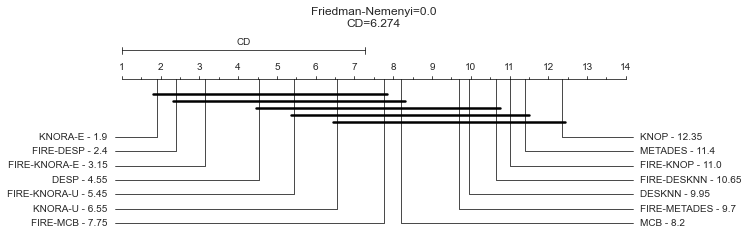

In [34]:
plot_comparisons(fried_result, names, cd, average_ranks)

#### <font color='green'>Save Results 

In [35]:
names = ["FIRE-KNORA-U", "KNORA-U", "FIRE-KNORA-E", "KNORA-E", "FIRE-METADES", "METADES",
         "FIRE-DESKNN", "DESKNN", "FIRE-MCB", "MCB", "FIRE-DESP", "DESP", "FIRE-KNOP", "KNOP"]

accuracy_list = [] 

for n in names: 
    accuracy_list.append(fireResultsDF[fireResultsDF.name==n].accuracy.to_list())
    
results = {"models": names, 
           "accuracy": accuracy_list}

res = pd.DataFrame.from_dict(results)

In [36]:
res

,models,accuracy
0,FIRE-KNORA-U,"[0.9692556634304207, 0.9719525350593312, 0.970..."
1,KNORA-U,"[0.9670981661272924, 0.9692556634304207, 0.967..."
2,FIRE-KNORA-E,"[0.9746494066882416, 0.9751887810140237, 0.975..."
3,KNORA-E,"[0.9751887810140237, 0.97680690399137, 0.97518..."
4,FIRE-METADES,"[0.97680690399137, 0.9449838187702265, 0.93365..."
5,METADES,"[0.9341963322545846, 0.948220064724919, 0.9358..."
6,FIRE-DESKNN,"[0.9379719525350594, 0.9056094929881338, 0.937..."
7,DESKNN,"[0.9401294498381877, 0.9056094929881338, 0.938..."
8,FIRE-MCB,"[0.9670981661272924, 0.9546925566343042, 0.963..."
9,MCB,"[0.9633225458468176, 0.9541531823085221, 0.962..."


In [39]:
# res.to_csv("Results/static_pool_results/des_static_pool_results_4_extend_for_CD.csv", index=False)